# Text Classification

The goal of this project is to perfrom sentiment analysis (positive or negative) on a dataset that contains movie reviews. The dataset is from IMDB.
Basically we will do Binary text classification

### Exploratory Data Analysis 

Imports that we need

In [1]:
import pandas as pd
import os 
from matplotlib import pyplot as plt
import seaborn as sns
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses

We need to put this to stop kernel from braking when I plot  - this happend only on certain machines 

In [2]:
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

### Import the dataset

Download the dataset from : https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

We created a folder named 'data' where we stored kept only the test and train folders and the README file that explains the dataset
We strongly recommend you to read this README file. There are other files besides these that we mooved into a folder in the root of the project named other-data

Under 'other-data' folder we will have the following structure:
 - unsup - folder
 - imdb.vocab
 - imdbEr.txt
 - labeledBow.feat
 - unsupBow.feat
 - urls_neg.txt
 - urls_pos.txt
 - urls_unsup.txt
  
Under 'data' folder we will have the following structure:
 - test - folder
 - train - folder
 - README

Under texst and train folder we will have two folders 'pos' and 'neg' for positive and negative reviews

We will only work with what we have in our 'data' folder

In [3]:
data_folder = 'data'

os.listdir(data_folder)

['README', 'test', 'train']

We have the ImdbEr.txt file that stores the polarity of the words, this was generated by the onwers of the dataset and does not directly helps us here but we want to see the words and their polarity in a dataset

We want to see what polarity means in this context

We can see that the polarity is between -4.5 (negative impact) and 4.5 (positive impact). The closer a polarity is to 0 the more neutral will be the impact of that word

In [4]:
polarity_df = pd.read_csv('./other-data/imdbEr.txt', header=None, names=['polarity'])
vocab_df = pd.read_csv('./other-data/imdb.vocab', header=None, names=['word'])

polarity_words_df = pd.merge(vocab_df, polarity_df, left_index=True, right_index=True)

polarity_words_df.sort_values(by='polarity', ascending=True)

,word,polarity
67306,subspace,-4.5
80133,bobbins,-4.5
46645,agis,-4.5
25509,wurb,-4.5
70915,schnass,-4.5
...,...,...
33815,double-d,4.5
70644,trestle,4.5
50326,grunner,4.5
33943,magorian,4.5


We want to see what words have neutral polarity

In [5]:
polarity_close_to_zero_filter = (polarity_words_df['polarity'] >= -0.001) & (polarity_words_df['polarity'] <= 0.001)
test_df = polarity_words_df[polarity_close_to_zero_filter]

test_df.sort_values(by='polarity')

,word,polarity
18702,mania,-0.000922
9137,elevate,-0.000898
35412,collin,-0.000827
4200,seed,-0.000801
10954,shields,-0.000781
...,...,...
10011,lambs,0.000730
6698,psychologist,0.000763
24151,stuffs,0.000799
20061,transplanted,0.000874


For now we can't deduce how the polarity is asigned to a word. On what crieteria is this decided. We need to further investigate

## Sentiment Analyisis
 We aim to do sentiment analysis on the reviews from imdb dataset and classify them into positive or negative reviews. The problem we face is a Binary classifier problem

First we need to grab the training, validation and testing data 

In [6]:
train_dir = os.path.join(data_folder, 'train')
test_dir = os.path.join(data_folder, 'test')

os.listdir(train_dir)

['neg', 'pos']

Let's see first how a review looks like:

In [7]:
def read_review(folder, file_name) -> str:
    file = os.path.join(folder, file_name)
    with open(file) as f:
        print(f.read())

positive_reviews_folder = os.path.join(train_dir, 'pos')

read_review(positive_reviews_folder, '0_9.txt')

Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High's satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I'm here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn't!


### Load the dataset

We need to get 3 datsets from the directories:

- training
- validation
- testing

In [8]:
batch_size = 32
seed = 42

def get_data(training_dir, testing_dir, batch_size, seed):
    
    raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
        training_dir,
        batch_size=batch_size,
        shuffle=True,
        seed=seed,
        validation_split=0.2,
        subset='training'
    )

    raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
        training_dir,
        batch_size=batch_size,
        shuffle=True,
        seed=seed,
        validation_split=0.2,
        subset='validation'
    )

    raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
        testing_dir,
        batch_size=batch_size,
    )

    return raw_train_ds, raw_val_ds, raw_test_ds


Grab the datasets

In [9]:
raw_train_ds, raw_val_ds, raw_test_ds = get_data(train_dir, test_dir, batch_size, seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


### Prepare the dataset for training

Here we need to standaridse the text, vectorize it, perform all kind of transformations over it, here we can go wild with the transformations but bascially we noticed that the texts contain some html tags and we need to get rid of them. First we replace the break-row tags with a whitescape. Than we remove the remaining tags

In [10]:
def remove_html_tags(text):
   br_clean = tf.strings.regex_replace(text, '<br />', ' ')
   clean_text = tf.strings.regex_replace(br_clean, '<[^>]*>', ' ')
   return clean_text

def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = remove_html_tags(lowercase)
    return tf.strings.regex_replace(stripped_html, '[%s]' % re.escape(string.punctuation), '')

We define the max_features(vocabulary) size and the sequence_length

- max_features -  the total unique number of words that we will consider from all the reviews
- sequence_length - the length of a review in tokens(words) 

We can play with these parameters since we know that we have around 90k unique words in all the reviews if we look at the imdb.vocab file

The vectorize_layer will take the create a 'bag-of-words' where we will have each unique word indexed by an integer that way we will have a vector of numbers instead of words

In [11]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize = custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length
)

Here we pass the all the train text through the vectorize layer

In [33]:
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

We have a method to vectoriez a single review

In [13]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [14]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))

first_review, first_label = text_batch[0], label_batch[0]

print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
text = custom_standardization(first_review)
print(text)
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Silent Night, Deadly Night 5 is the very last of the series, and like part 4, it\'s unrelated to the first three except by title and the fact that it\'s a Christmas-themed horror flick.<br /><br />Except to the oblivious, there\'s some obvious things going on here...Mickey Rooney plays a toymaker named Joe Petto and his creepy son\'s name is Pino. Ring a bell, anyone? Now, a little boy named Derek heard a knock at the door one evening, and opened it to find a present on the doorstep for him. Even though it said "don\'t open till Christmas", he begins to open it anyway but is stopped by his dad, who scolds him and sends him to bed, and opens the gift himself. Inside is a little red ball that sprouts Santa arms and a head, and proceeds to kill dad. Oops, maybe he should have left well-enough alone. Of course Derek is then traumatized by the incident since he watched it from the stairs, but he doesn\'t grow up to be some killer Santa, he just stops talking.<br /><br />T

We can get the word by index using get_vocabulary() method

In [15]:
print("2 ---> ", vectorize_layer.get_vocabulary()[2])
print("1287 ---> ", vectorize_layer.get_vocabulary()[1287])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

2 --->  the
1287 --->  silent
Vocabulary size: 10000


We want to see the vocabulary

Here we see how the first 100 words from the vocabulary are indexed

In [16]:
contor = 1

vocabulary = vectorize_layer.get_vocabulary()
for index, word in enumerate(vocabulary):
    print(f"{index} ---> {word}")
    contor+=1
    if contor == 100:
        break

0 ---> 
1 ---> [UNK]
2 ---> the
3 ---> and
4 ---> a
5 ---> of
6 ---> to
7 ---> is
8 ---> in
9 ---> it
10 ---> i
11 ---> this
12 ---> that
13 ---> was
14 ---> as
15 ---> for
16 ---> with
17 ---> movie
18 ---> but
19 ---> film
20 ---> on
21 ---> not
22 ---> you
23 ---> are
24 ---> his
25 ---> have
26 ---> be
27 ---> he
28 ---> one
29 ---> its
30 ---> all
31 ---> at
32 ---> by
33 ---> an
34 ---> they
35 ---> from
36 ---> who
37 ---> so
38 ---> like
39 ---> her
40 ---> just
41 ---> or
42 ---> about
43 ---> has
44 ---> out
45 ---> if
46 ---> some
47 ---> there
48 ---> what
49 ---> good
50 ---> more
51 ---> when
52 ---> very
53 ---> even
54 ---> my
55 ---> she
56 ---> up
57 ---> no
58 ---> time
59 ---> would
60 ---> which
61 ---> only
62 ---> really
63 ---> story
64 ---> their
65 ---> were
66 ---> had
67 ---> see
68 ---> can
69 ---> me
70 ---> than
71 ---> we
72 ---> much
73 ---> well
74 ---> been
75 ---> get
76 ---> will
77 ---> also
78 ---> other
79 ---> people
80 ---> bad
81 ---> into
82 

### Find the average number of words per review

In [17]:
text_batch, label_batch = next(iter(raw_train_ds))
first_review = text_batch[0]
print("Review:  ", first_review)

Review:   tf.Tensor(b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.', shape=(), dtype=string)


In [18]:
review_indices = []
num_words = []
number_of_reviews = 0

for i, (text_batch, _) in enumerate(raw_train_ds):
    for j, review in enumerate(text_batch.numpy()):
        review_indices.append(number_of_reviews)
        num_words.append(len(review.split()))
        number_of_reviews +=1

Now we must create a dataset with the index of the review and the number of words in that review, and we can find the average number of reviews and plot their distribution

In [19]:
reviews_df = pd.DataFrame({'num_words': num_words})
reviews_df.describe()

,num_words
count,20000.000000
mean,234.266000
std,174.370804
min,10.000000
25%,127.000000
50%,175.000000
75%,286.000000
max,2470.000000


We want to see the 90th percentile for the number of words

In [20]:
# Calculate the 90th percentile
percentile_90 = reviews_df['num_words'].quantile(0.9)

print("90th percentile of num_words column:", percentile_90)

90th percentile of num_words column: 457.1000000000022


We want to plot the distribution of number of words per review

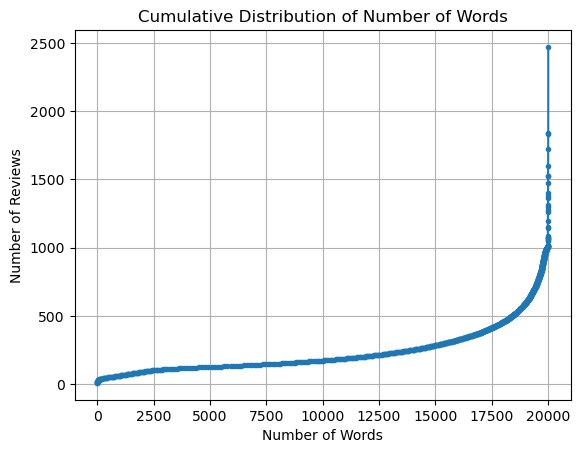

In [21]:
# Sort the DataFrame by the 'num_words' column
reviews_df_sorted = reviews_df.sort_values(by='num_words')

# Calculate the cumulative distribution
cumulative_distribution = (reviews_df_sorted
                            .reset_index(drop=True)
                            .reset_index()
                            .groupby('num_words')
                            .count()
                            .cumsum())

# Plot the line plot
plt.plot(cumulative_distribution['index'], cumulative_distribution.index,  marker='.')
plt.title('Cumulative Distribution of Number of Words')
plt.xlabel('Number of Words')
plt.ylabel('Number of Reviews')
plt.grid(True)
plt.show()

We can also plot the number of words by binning them

C:\Users\Hori\AppData\Local\Temp\ipykernel_2520\1667288571.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  word_bins_count = reviews_df.groupby('word_bins').size()


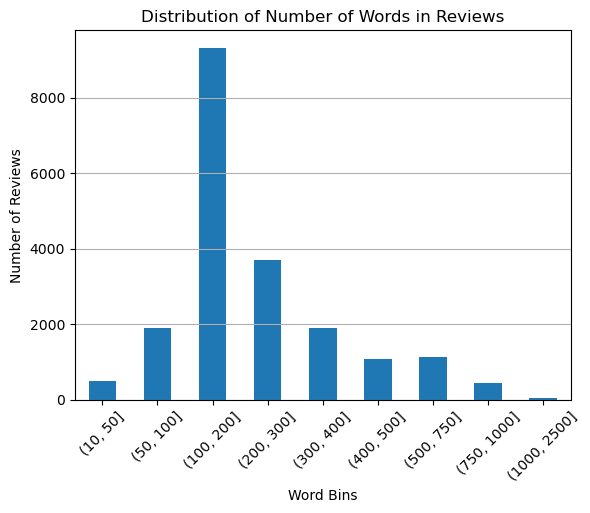

In [22]:
bins = [10, 50, 100, 200, 300, 400, 500, 750, 1000, 2500]  # Define your own bins as needed

# Bin the number of words
reviews_df['word_bins'] = pd.cut(reviews_df['num_words'], bins=bins)

# Group by the word bins and count the number of reviews in each bin
word_bins_count = reviews_df.groupby('word_bins').size()

# Plot the bar plot
word_bins_count.plot(kind='bar')
plt.title('Distribution of Number of Words in Reviews')
plt.xlabel('Word Bins')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(axis='y')
plt.show()

From this we can conclude that around 250 number of tokens per vector is a correct assumption

### Vectorize and standardize the datasets

In [23]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

### Configure the dataset for performance to use cache

In [24]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Create the model

We define the architecture of the model starting with an embedding layer this will transform each word in an embeding of a sepcific size - a vector of numbers.

The GlobalAveragePooling1D layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.
The pooling operation that computes the average value of each feature map along the temporal dimension of the input tensor, resulting in a condensed representation of the input sequence

The MaxPooling1D layer will consider each group of 4 consecutive words in the  input sequence and take the maximum value within each group. This effectively reduces the length of the sequence by a factor of 4, as only the maximum value from each group of 4 words is retained in the output sequence

In [63]:
# This is an integer indicating the dimensionality of the embedding space. It determines the size of the embedding vectors. For example, 
# if embedding_dim is set to 16, each word in the vocabulary will be represented by a dense vector of length 16

embedding_dim = 16

baseline_model = [
    layers.Embedding(max_features, embedding_dim),
    layers.Dropout(0.5),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
]

lstm_model = [
    layers.Embedding(max_features, embedding_dim),
    layers.Dropout(0.1),
    layers.LSTM(128, return_sequences=True),
    layers.LSTM(128, return_sequences=True),
    layers.LSTM(128),  # Last LSTM layer usually doesn't return sequences
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
]

conv1d_model = [
    layers.Embedding(max_features, embedding_dim),
    layers.Conv1D(64, 5, activation='relu'),
    layers.MaxPooling1D(pool_size=4),
    layers.Conv1D(128, 5, activation='relu'),
    layers.GlobalMaxPooling1D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
]

model = tf.keras.Sequential(baseline_model)

model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_39 (Embedding)    (None, None, 16)          160000    
                                                                 
 dropout_62 (Dropout)        (None, None, 16)          0         
                                                                 
 global_average_pooling1d_15  (None, 16)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_63 (Dropout)        (None, 16)                0         
                                                                 
 dense_52 (Dense)            (None, 1)                 17        
                                                                 
Total params: 160,017
Trainable params: 160,017
Non-trainable params: 0
_______________________________________________

### Callbacks

We have two callbacks, one that saves the best model looking at loss and another looking at accuracy

In [64]:
best_loss_path = './models/best_loss.h5'
best_loss_callback = tf.keras.callbacks.ModelCheckpoint(filepath=best_loss_path,
                                                 save_best_only=True,
                                                 monitor='val_loss',
                                                 verbose=1)

In [65]:
best_accuracy_path = './models/best_accuracy.h5'
best_accuracy_callback = tf.keras.callbacks.ModelCheckpoint(filepath=best_accuracy_path,
                                                 save_best_only=True,
                                                 monitor='val_binary_accuracy',
                                                 verbose=1)

### Compile the model

In [66]:
model.compile(loss=losses.BinaryCrossentropy(), optimizer='adam', metrics=[tf.metrics.BinaryAccuracy(threshold=0.5)])

### Train the model

In [67]:
epochs = 20

history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[best_loss_callback, best_accuracy_callback])

Epoch 1/20


615/625 [============================>.] - ETA: 0s - loss: 0.6770 - binary_accuracy: 0.6571
Epoch 1: val_loss improved from inf to 0.64511, saving model to ./models\best_loss.h5

Epoch 1: val_binary_accuracy improved from -inf to 0.75780, saving model to ./models\best_accuracy.h5
625/625 [==============================] - 4s 6ms/step - loss: 0.6765 - binary_accuracy: 0.6586 - val_loss: 0.6451 - val_binary_accuracy: 0.7578
Epoch 2/20
615/625 [============================>.] - ETA: 0s - loss: 0.5959 - binary_accuracy: 0.7729
Epoch 2: val_loss improved from 0.64511 to 0.54986, saving model to ./models\best_loss.h5

Epoch 2: val_binary_accuracy improved from 0.75780 to 0.80240, saving model to ./models\best_accuracy.h5
625/625 [==============================] - 3s 5ms/step - loss: 0.5951 - binary_accuracy: 0.7734 - val_loss: 0.5499 - val_binary_accuracy: 0.8024
Epoch 3/20
617/625 [============================>.] - ETA: 0s - loss: 0.5045 - binary_accuracy: 0.8156
Epoch 3: val_loss improved 

Plot the model's perfromance

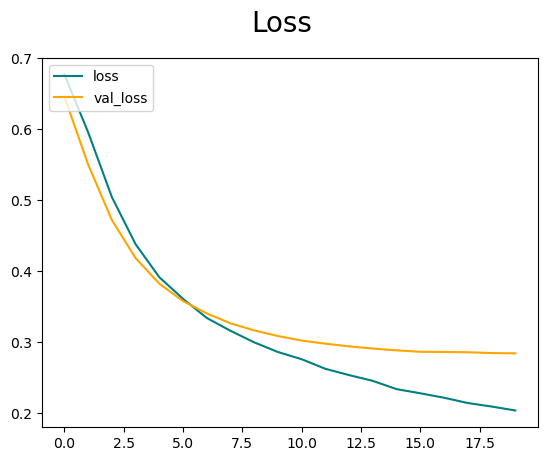

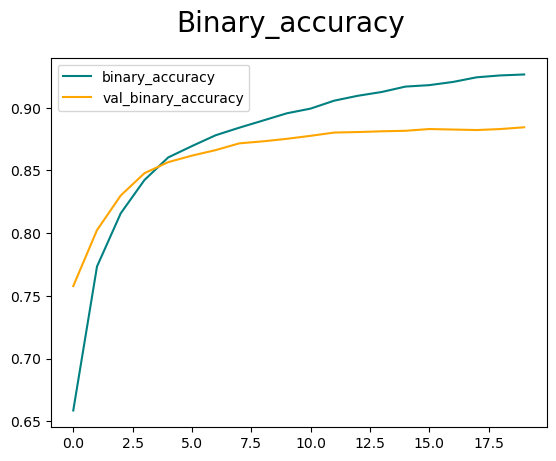

In [68]:
history_metrics = history.history

def plot_metrics(history, metric):
    if metric not in history:
        raise ValueError(f"{metric} not found in history. Available metrics: {', '.join(history.keys())}")
    
    fig = plt.figure()
    plt.plot(history[metric], color='teal', label=metric)
    val_metric = 'val_' + metric
    plt.plot(history[val_metric], color='orange', label=val_metric)
    fig.suptitle(metric.capitalize(), fontsize=20)
    plt.legend(loc="upper left")
    plt.show()

plot_metrics(history_metrics, metric='loss')
plot_metrics(history_metrics, metric='binary_accuracy') 

We can notice that the model is overfitting now

### Evaluate the model

In [69]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

  1/782 [..............................] - ETA: 9s - loss: 0.2054 - binary_accuracy: 0.9375

782/782 [==============================] - 1s 2ms/step - loss: 0.3078 - binary_accuracy: 0.8740
Loss:  0.3078429400920868
Accuracy:  0.8740000128746033


### Test on new data

In [70]:
examples_raw = tf.constant([
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
])


# Assuming labels are available, create a dummy labels tensor for demonstration
labels = tf.constant([1, 1, 0])

# Use tf.data.Dataset.from_tensor_slices to create a dataset from examples_raw and labels
dataset = tf.data.Dataset.from_tensor_slices((examples_raw, labels))

# Use map to apply vectorize_text_fn to each element of the dataset
examples = dataset.map(vectorize_text)

model.predict(examples)

3/3 [==============================] - 0s 4ms/step


array([[0.647994  ],
       [0.44617128],
       [0.3426247 ]], dtype=float32)

### Understaning how vocabulary works

Here we just played a bit with creating a smaller vocabulary to see how it works

In [71]:
examples_raw = tf.constant([
  "The movie was great !",
  "The movie was okay.",
  "The movie was terrible..."
])


# Assuming labels are available, create a dummy labels tensor for demonstration
labels = tf.constant([1, 1, 0])

# Use tf.data.Dataset.from_tensor_slices to create a dataset from examples_raw and labels
dataset = tf.data.Dataset.from_tensor_slices((examples_raw, labels))


dataset_text_only = dataset.map(lambda example, label: example)

# Specify the batch size
batch_size = 1
# Create batches of examples ignoring labels
batched_dataset = dataset_text_only.batch(batch_size)
train_text = batched_dataset.map(lambda x: x)
vectorize_layer.adapt(train_text)

text_batch = next(iter(batched_dataset))


first_review = text_batch[0]

print("Review", first_review)
print("Vectorized review", vectorize_text(first_review, 1))

contor = 1

vocabulary = vectorize_layer.get_vocabulary()
for index, word in enumerate(vocabulary):
    print(f"{index} ---> {word}")
    contor+=1
    if contor == 100:
        break

Review tf.Tensor(b'The movie was great !', shape=(), dtype=string)
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[3, 4, 2, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0]], dtype=int64)>, 1)


### Visualizing the word embeddings

[[ 0.00180566 -0.00611004 -0.01612602 ...  0.00547629 -0.01107974
   0.00493094]
 [-0.00694327  0.0062486   0.01258441 ...  0.04691257  0.05617985
  -0.03285553]
 [-0.03261536 -0.02127986  0.0284508  ... -0.10937496 -0.00453381
   0.00263692]
 ...
 [ 0.4223463   0.21606806 -0.4210971  ...  0.16660848  0.29646638
  -0.2957389 ]
 [-0.02864985  0.14932004 -0.17241442 ...  0.28194836  0.1364874
   0.04417644]
 [ 0.21480478  0.11913897 -0.08641058 ...  0.06713204  0.24535313
  -0.34473875]]


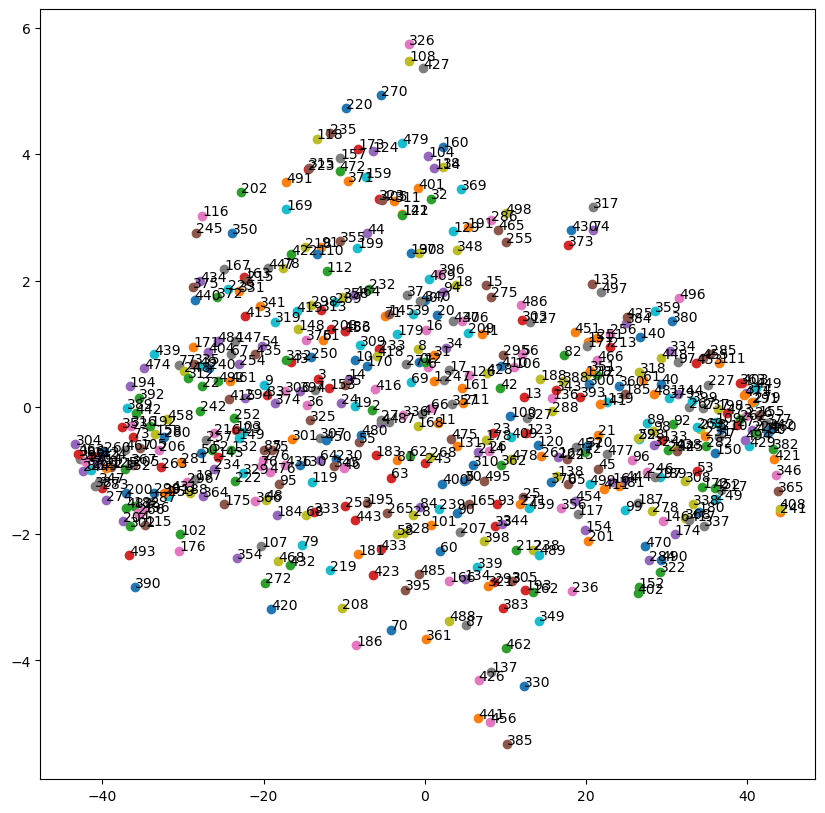

In [72]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# Assuming 'embedding_layer' is the embedding layer of your model
embedding_matrix = model.layers[0].get_weights()[0]

# Extract a subset of word embeddings for visualization (optional)
num_words_to_visualize = 500
embedding_matrix_subset = embedding_matrix[:num_words_to_visualize]

print(embedding_matrix_subset)

# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2)
embeddings_2d = tsne.fit_transform(embedding_matrix_subset)

# Visualize the word embeddings in 2D
plt.figure(figsize=(10, 10))
for i in range(len(embeddings_2d)):
    plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1])
    plt.annotate(str(i), (embeddings_2d[i, 0], embeddings_2d[i, 1]))
plt.show()